# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 3</span>

In this third notebook we want to study the applications of Monte Carlo Methods to the options pricing. In praticular we want to compute at time $t=0$ **via Monte Carlo** the European call-option price, $C[S(0),0]$, and put-option price, $P[S(0),0]$.


We know that Black-Scholes theory assumes that the time evolution of the asset price is stochastic and exhibits geometric Brownian motion (GBM) with constant risk-free interest rate  $r$  and volatility  $\sigma$ .

Black-Scholes <span style="color:blue"> analytic solution </span> for the price at time t<T:
- European Call-option price:
$$ C\left[ S(t),t \right] = S(t) N(d_1) -K e^{-r(T-t)} N(d_2) $$
- European Put-option price:
$$ P\left[ S(t),t \right] = S(t) \left[ N(d_1)-1\right] -K e^{-r(T-t)} \left[ N(d_2)-1\right]$$

where 
$$d_1 = \frac{1}{\sigma\sqrt{T-t}}\left[ \ln \left( \frac{S(t)}{K} \right) + \left( r+\frac{\sigma^2}{2} (T-t) \right)\right]$$

where $d_2 = d_1 - \sigma\sqrt{T-t}$, and where
$$ N(x) = \int_{-\infty}^{x} dz \, e^{-\frac{z^2}{2}} = \frac{1}{2} \left[ 1+ {\rm erf} \left( \frac{x}{\sqrt{2}}\right) \right]$$
is the cumulative of Gaussian $\sim \mathcal{N}(\mu=0,\sigma^2=1)$,
and where
$${\rm erf}(x) = \frac{2}{\sqrt{\pi}}\int_{0}^{x} dz \, e^{-z^2}$$

Supposing to have the following parameters: 
- asset price at $t=0$: $S(0)=100$
- delivery time: $T=1$
- strike price: $K=100$
- risk-free interest rate: $r=0.1$
- volatility: $\sigma=0.25$

our computation will be performed following two different samplings:
- direct sampling of the final asset price $S(T)$</span> for a $GBM(r,\sigma^2)$
- discretized sampling of $GBM(r,\sigma^2)$ path of the asset price</span> 
dividing $[0,T]$ in $10^2$ time intervals: $S(0)$, $S(t_1)$, $S(t_2)$, ... up to $S(t_{100}=T=1)$

First of all we implement the analytic solution for the Black-Scholes model: in this way we obtain two values useful to make a comparison with the results.

In [1]:
#common libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import re
from matplotlib.pyplot import figure
from scipy.optimize import curve_fit
from scipy.special import erf


# data
S0 = 100.
K = 100.
T = 1.
r = 0.1
sigma = 0.25
t=0

def N(x):
    return 0.5 * (1. + erf(x / np.sqrt(2.)))

def black_scholes(S0, K, T, r, sigma):
    d1 = 1./(sigma * np.sqrt(T)) * (np.log(S0 / K) + (r + (sigma**2) / 2.) * T)
    d2 = d1 - sigma * np.sqrt(T)
    C = S0 * N(d1) - K * np.exp(-r * T) * N(d2)
    P = S0 *(N(d1) - 1.) - K * np.exp(-r * T) * (N(d2)-1.)
    return C, P

if __name__ == "__main__":
    call, put = black_scholes(S0, K, T, r, sigma)
    print(" == BLACK-SCHOLES ==")
    print("call: ", call)
    print("put: ", put)

 == BLACK-SCHOLES ==
call:  14.975790778311286
put:  5.4595325819072364


As usual, in order to compute statistical uncertainties, we resort to data blocking:

In [2]:
def error(AV,AV2,n):  # Function for statistical uncertainty estimation
    if n==0: 
        return 0 #it is not possible to compute the error if we have just one block: we put the error equal to zero
    else:
        return np.sqrt((AV2 - AV**2)/n)


def observable(data): #function useful to the creation of the averages an the relative errors in the blocking method
    sum_prog = 0.
    sum2_prog = 0.
    val = np.zeros((len(data), 2))
    for i in range(len(data)):
        sum_prog = sum_prog + data[i]
        sum2_prog = sum2_prog + data[i]*data[i]
        ave = sum_prog / (i+1)
        ave2 = sum2_prog / (i+1)
        val[i, 0] = ave
        val[i, 1] = error(ave,ave2,i)
    return val   

In particular, for the sampling we consider $1000000$ of throws divided into $100$ blocks.

In [3]:
#Get information from file about the pseudo random generation
file = open("data/info_ex3.1.dat", "r")
for i in file.readlines():
    print(i)
file.close()

file = open("data/info_ex3.1.dat", "r")
file = file.read()
s = re.findall(r"[-+]?\d*\.\d+|\d+", file)

#Read data from file
data_CALL = np.loadtxt("data/CALL_ex3.1.dat")
data_PUT = np.loadtxt("data/PUT_ex3.1.dat")

Number of blocks: 100

Number of throws per block: 10000

Number of steps per throw: 100



### Call option pricing: direct and discretized sampling

First of al we consider the call option.
In order to perform the direct sampling we resort to the asset price formula: $$S(t) = S(0) \exp\left[ \left(\mu-\frac{1}{2}\sigma^2\right)t+\sigma W(t) \sqrt{t} \right]$$ where $S(0)$ is the intial asset price and $W(t)$ is a random number normally distributed following $\mathcal{N}(0,t)$.
For the discrete sampling we resort to the discrete asset price formula: 
$$S(t_{i+1}) = S(t_i) \exp\left[ \left(\mu-\frac{1}{2}\sigma^2\right)(t_{i+1}-t_i)
    +\sigma Z_{i+1}\sqrt{t_{i+1}-t_i}\right]$$
    with $Z_i \sim \mathcal{N}(0,1)$ and $t_1 < t_2 < … < t_n$

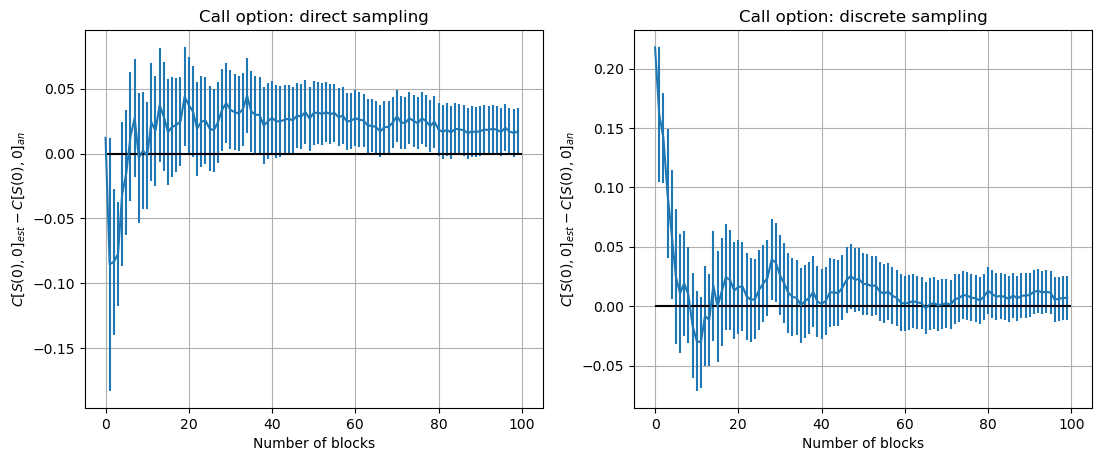

In [4]:
x = np.arange(int(s[0])) 
# build the observables, i.e. the averages on each block
y_direct = observable(data_CALL[:,0])
y_disc = observable(data_CALL[:,1])

fig, axes = plt.subplots(1, 2,figsize=(13,5),dpi=100)

axes[0].errorbar(x,y_direct[:,0]-call,yerr=y_direct[:,1])
axes[0].hlines(0,0,100, color = "black")
axes[0].set_title("Call option: direct sampling")

axes[1].errorbar(x,y_disc[:,0]-call,yerr=y_disc[:,1])
axes[1].hlines(0,0,100, color = "black")
axes[1].set_title("Call option: discrete sampling")

for ax in axes:
    ax.set_xlabel("Number of blocks")
    ax.set_ylabel(r"$C[S(0),0]_{est} - C[S(0),0]_{an}$")
    ax.grid(True)


In the plots above we show the estimate of the price for a call option with both samplings, direct and discrete. We translate the trends exploiting the knowledge of the analytical result, so we expect the estimate to converge to zero.
In particular, for the direct sampling we get: $$C[S(0),0] = 14.992 \pm 0.018$$ and for the discrete sampling we get: $$C[S(0),0] = 14.982 \pm 0.018$$
The black line represents the analytical result.

### Put option pricing: direct and discretized sampling

The same techniques are used also for the estimate of the put option price.

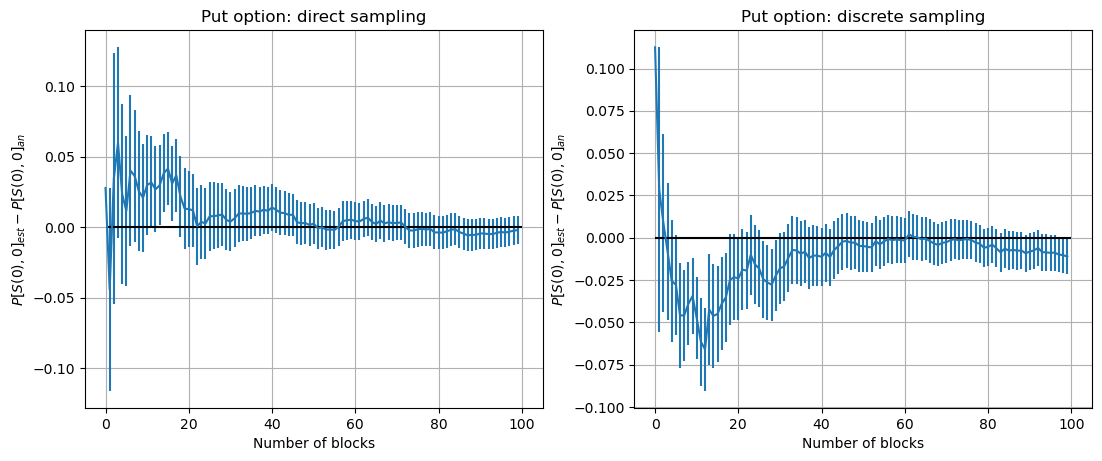

In [5]:
x = np.arange(int(s[0])) 
# build the observables, i.e. the averages on each block
y_direct = observable(data_PUT[:,0])
y_disc = observable(data_PUT[:,1])

fig, axes = plt.subplots(1, 2,figsize=(13,5),dpi=100)

axes[0].errorbar(x,y_direct[:,0]-put,yerr=y_direct[:,1])
axes[0].hlines(0,0,100, color = "black")
axes[0].set_title("Put option: direct sampling")

axes[1].errorbar(x,y_disc[:,0]-put,yerr=y_disc[:,1])
axes[1].hlines(0,0,100, color = "black")
axes[1].set_title("Put option: discrete sampling")

for ax in axes:
    ax.set_xlabel("Number of blocks")
    ax.set_ylabel(r"$P[S(0),0]_{est} - P[S(0),0]_{an}$")
    ax.grid(True)


In the plots above we show the estimate of the price for a put option with both samplings, direct and discrete. We translate the trends exploiting the knowledge of the analytical result, so we expect the estimate to converge to zero.
In particular, for the direct sampling we get: $$P[S(0),0] = 5.457 \pm 0.010$$ and for the discrete sampling we get: $$P[S(0),0] = 5.448 \pm 0.010 .$$
The black line represents the analytical result.

The only difference between these estimations is the sampling method of $S(T)$. If in the direct sampling we estimate directly the value after a unique step $T$ which brings the system from $S(0)$ to $S(T)$, in the discrete sampling we have a walk of $100$ steps.

In conclusion, we can say that the results obtained are in agreement with the theory and that substantially there is not any difference between the uncertainties of the two methods. This is due to the fact that the discretization of the process is exact.